In [1]:
dataset_name = "artificial_cd_3_random_removal"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess Dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '5min', data))

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="5min", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2014-04-01 16:40:00",
                      "2014-04-02 09:20:00",
                      "2014-04-03 02:00:00",
                      "2014-04-03 18:40:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2014-04-01 00:00:00
End date:  2014-04-04 11:15:00
Missing time stamps: 
 DatetimeIndex(['2014-04-01 01:20:00', '2014-04-02 02:05:00',
               '2014-04-03 11:50:00'],
              dtype='datetime64[ns]', freq=None)
Length:  1000
Time step size:  5min
Start Date:  2014-04-01 00:00:00
End Date:  2014-04-04 11:15:00
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [200, 400, 600, 800]


# GLM

In [4]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

  0%|          | 0/997 [00:00<?, ?it/s]

Initial Mean 5.630199007903333
Initial StdDev 2.626651549175287
eta:  0.5
lambda:  0.99
MSE:  17.587676479581784
Initial Mean 5.630199007903333
Initial StdDev 2.626651549175287


100%|██████████| 997/997 [00:00<00:00, 28568.35it/s]

eta:  0.5
lambda:  0.999
MSE:  25.182834173700343
Initial Mean 5.630199007903333
Initial StdDev 2.626651549175287
eta:  0.5
lambda:  0.9999
MSE:  28.714419911069943
Initial Mean 5.630199007903333
Initial StdDev 2.626651549175287



100%|██████████| 997/997 [00:00<00:00, 28933.24it/s]

eta:  1
lambda:  0.99
MSE:  14.246752189725125
Initial Mean 5.630199007903333
Initial StdDev 2.626651549175287
eta:  1
lambda:  0.999
MSE:  16.60403927641908
Initial Mean 5.630199007903333
Initial StdDev 2.626651549175287


eta:  1
lambda:  0.9999
MSE:  17.31348890510218

best params:  eta 1 lambda 0.99


100%|██████████| 997/997 [00:00<00:00, 28171.69it/s]


Initial Mean 5.630199007903333
Initial StdDev 2.626651549175287


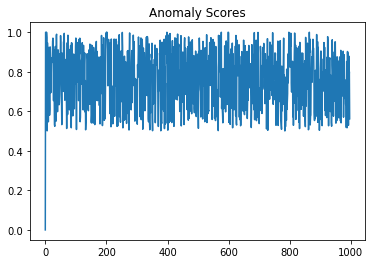

Time:  0.13521409034729004


['anomaly_scores/GLM/artificial_cd_3_random_removal_random_removal']

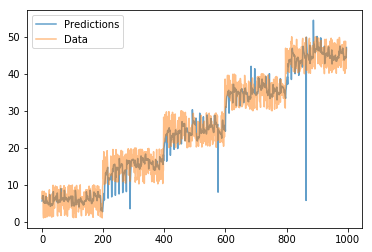

In [5]:
save_path = "anomaly_scores/GLM/" + dataset_name+ "_random_removal"
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=int(best_params[4:6]),
                     lambda_=float(best_params[14:]),
                     plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# SARIMA


 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : 758.302
 ARIMA(1,0,0) with non-zero mean : 761.1097
 ARIMA(0,0,1) with non-zero mean : 760.8728
 ARIMA(0,0,0) with zero mean     : 755.1736
 ARIMA(1,0,1) with non-zero mean : Inf

 Best model: Regression with ARIMA(0,0,0) errors 



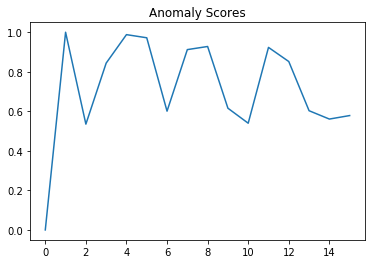

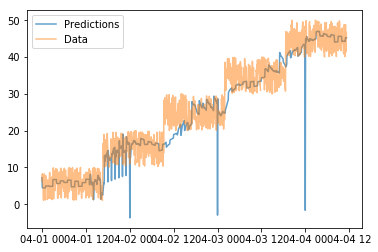

Time:  1.7513937950134277


['anomaly_scores/SARIMA_auto/artificial_cd_3_random_removal_random_removal']

In [6]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name+ "_random_removal"
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Prophet

In [7]:
# optimization step

step_sizes = [100, 200, 300, 400, 500]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for changepoint_prior_scale in changepoint_prior_scales:

        mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=changepoint_prior_scale,
                                  step_size=step_size,
                                  optimize=True)
        print("Step Size: ", step_size)
        print("Changepoint Prior Scale: ", changepoint_prior_scale)
        print("MSE: ",mse)

        key_str = "Step Size " + str(step_size) +" Changepoint Prior Scale" + str(changepoint_prior_scale)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.01
MSE:  10.027124924320319


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.05
MSE:  10.0229011768375


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.1
MSE:  7.894930808793966


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.15
MSE:  7.336202348449604


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.2
MSE:  7.116003848853249


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.01
MSE:  10.027124924320319


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.05
MSE:  10.0229011768375


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.1
MSE:  7.894930808793966


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.15
MSE:  7.336202348449604


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.2
MSE:  7.116003848853249


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  300
Changepoint Prior Scale:  0.01
MSE:  10.027124924320319


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  300
Changepoint Prior Scale:  0.05
MSE:  10.0229011768375


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  300
Changepoint Prior Scale:  0.1
MSE:  7.894930808793966


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  300
Changepoint Prior Scale:  0.15
MSE:  7.336202348449604


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  300
Changepoint Prior Scale:  0.2
MSE:  7.116003848853249


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  400
Changepoint Prior Scale:  0.01
MSE:  10.027124924320319


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  400
Changepoint Prior Scale:  0.05
MSE:  10.0229011768375


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  400
Changepoint Prior Scale:  0.1
MSE:  7.894930808793966


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  400
Changepoint Prior Scale:  0.15
MSE:  7.336202348449604


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  400
Changepoint Prior Scale:  0.2
MSE:  7.116003848853249


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  500
Changepoint Prior Scale:  0.01
MSE:  10.027124924320319


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  500
Changepoint Prior Scale:  0.05
MSE:  10.0229011768375


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  500
Changepoint Prior Scale:  0.1
MSE:  7.894930808793966


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  500
Changepoint Prior Scale:  0.15
MSE:  7.336202348449604
Step Size:  500
Changepoint Prior Scale:  0.2
MSE:  7.116003848853249

best params:  Step Size 100 Changepoint Prior Scale0.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


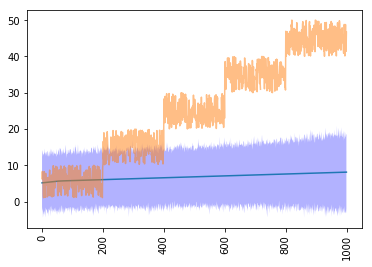

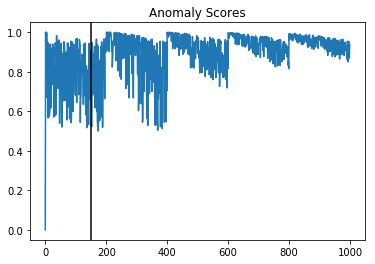

Time:  4.162195682525635


['anomaly_scores/Prophet/artificial_cd_3_random_removal_random_removal']

In [8]:
save_path = "anomaly_scores/Prophet/" + dataset_name+ "_random_removal"
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=.2,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

In [9]:
# no seasonality so no stl